In [2]:
#Importing Libraries
#Essential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset

#Transformers
from transformers import BertTokenizer, BertForQuestionAnswering, Trainer, TrainingArguments,BertTokenizerFast,EvalPrediction,pipeline, AutoModelForQuestionAnswering, AutoTokenizer

#Sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

#Streamlit
import streamlit as st
from pyngrok import ngrok
import time
import threading
import os


2025-05-22 06:40:12.365549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747896012.591820      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747896012.665476      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#data loading
dataset = load_dataset("squad_v2", split="train[:10000]")

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'question': 'When did Beyonce start becoming popular?', 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}


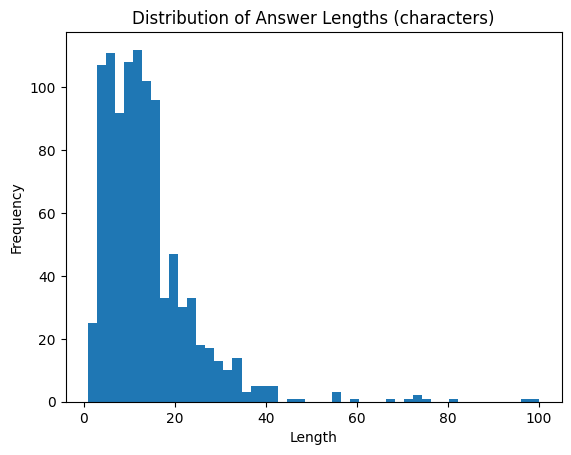

In [4]:
#printing a sample
print(dataset[0])

# Analyze answer length distribution
def get_answer_lengths(dataset_split):
    lengths = []
    for example in dataset_split:
        if example['answers']['answer_start']:
            lengths.append(len(example['answers']['text'][0]))
    return lengths

train_lengths = get_answer_lengths(dataset.select(range(1000)))
plt.hist(train_lengths, bins=50)
plt.title('Distribution of Answer Lengths (characters)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [5]:
#Bert Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    contexts = examples["context"]
    answers = examples["answers"]
  #Tokenizer Configurations
    inputs = tokenizer(
        questions,
        contexts,
        max_length=384,
        truncation="only_second",  #Only Truncate the contexts
        stride=128, #Splitting into overloaping chnuks
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    offset_mapping = inputs.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = inputs["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id) #Qiestion start index

        sequence_ids = inputs.sequence_ids(i)
        sample_idx = sample_map[i]
        answer = answers[sample_idx]

        if len(answer["answer_start"]) == 0: #when empty answer
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answer["answer_start"][0] #start of the answer
            end_char = start_char + len(answer["text"][0]) #end of the answer

            # Find context token indices
            context_start = sequence_ids.index(1)
            context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)

            start_pos = cls_index
            end_pos = cls_index
            for idx in range(context_start, context_end + 1):
                if offsets[idx][0] <= start_char < offsets[idx][1]:
                    start_pos = idx
                if offsets[idx][0] < end_char <= offsets[idx][1]:
                    end_pos = idx
                    break

            start_positions.append(start_pos)
            end_positions.append(end_pos)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names) #applying preprocessing

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
#data splitting
split_dataset = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_set = split_dataset['train']
validatation_set = split_dataset['test']

In [7]:
#Computing f1 score
def compute_metrics(p: EvalPrediction):
    predictions, labels = p
    start_preds, end_preds = predictions
    start_labels, end_labels = labels

    # Calculate F1 scores
    start_f1 = f1_score(start_labels, np.argmax(start_preds, axis=1), average="macro")
    end_f1 = f1_score(end_labels, np.argmax(end_preds, axis=1), average="macro")

    return {
        "start_f1": start_f1,
        "end_f1": end_f1,
        "avg_f1": (start_f1 + end_f1) / 2
    }



In [8]:
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
args = TrainingArguments(
    output_dir="bert-finetuned-squad", #Directory to save model checkpoints and logs.
    run_name="bert-squad-run",
    eval_strategy ="epoch", #When to eval the model -> after each epoc
    save_strategy ="epoch", #check point saved at each epoc
    learning_rate=2e-5,
    per_device_train_batch_size=8, #Number of samples assigned to each GPU during training
    per_device_eval_batch_size=8, #same but during evalutaion
    num_train_epochs=4, #Number of epocs
    weight_decay=0.01, #Reglarization
    push_to_hub=False,
    logging_dir="./logs",                      #  Required for logging
    logging_strategy="steps",                  #  Enable logging
    logging_steps=100,                         #  Log every 100 steps
    report_to="none",                          #  Disable external logging tools like WandB
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_set,
    eval_dataset=validatation_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3517019950.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
trainer.train()

Epoch,Training Loss,Validation Loss,Start F1,End F1,Avg F1
1,1.527000,1.385012,0.516836,0.546346,0.531591
2,1.035000,1.280725,0.559763,0.600943,0.580353
3,0.762400,1.325989,0.570978,0.606469,0.588723
4,0.478100,1.439299,0.574116,0.595774,0.584945


TrainOutput(global_step=4056, training_loss=1.066779023796849, metrics={'train_runtime': 1804.851, 'train_samples_per_second': 17.972, 'train_steps_per_second': 2.247, 'total_flos': 6356566201116672.0, 'train_loss': 1.066779023796849, 'epoch': 4.0})

In [34]:
trainer.save_model("bert-finetuned-squad")
tokenizer.save_pretrained("bert-finetuned-squad")

('bert-finetuned-squad/tokenizer_config.json',
 'bert-finetuned-squad/special_tokens_map.json',
 'bert-finetuned-squad/vocab.txt',
 'bert-finetuned-squad/added_tokens.json',
 'bert-finetuned-squad/tokenizer.json')

In [10]:
from transformers import pipeline

qa_pipeline = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Sample test
context = """
The Great Wall of China is a series of fortifications made of stone, brick,
tamped earth, wood, and other materials, generally built along an east-to-west line across
the historical northern borders of China to protect the Chinese states against invasions.
Several walls were being built as early as the 7th century BC,
but the most famous sections were constructed by the Ming dynasty (1368–1644).
"""

questions = [
    "Which Chinese dynasty built the most famous sections of the Great Wall?",
    "What was the primary purpose of the Great Wall of China?",
    "When was the wall build?"
           ]
for question in questions:
    result = qa_pipeline(question=question, context=context)
    print(f"Question: {question}")
    print(f"Answer: {result['answer']}")
    print(f"Score: {result['score']:.4f}")

Device set to use cuda:0


Question: Which Chinese dynasty built the most famous sections of the Great Wall?
Answer: the Ming dynasty
Score: 0.4801
Question: What was the primary purpose of the Great Wall of China?
Answer: fortifications
Score: 0.1651
Question: When was the wall build?
Answer: 7th century BC
Score: 0.7071
